# Project 6: Working with Geocoded Data

## Building Maps in _geopandas_

In this lesson we will download COVID-19 data from data.world. We will normalize the data to compare spread between counties. Were we to simply plot the total number of cases or deaths by county, the results would be biased as counties with larger populations would likely have more cases and more deaths. We will observe how the spread developed across the country, starting in the northeast, eventually making its way to other regions.

### Installing geopandas

Although there is a geopandas installation available using the *conda install* command in you command line shell, that package is incomplete for our purposes. We will need to install dependencies - in this order: *GDAL*,*Fiona*, and *Shapely* - for geopandas before installing geopandas. I have included the *.whl* files for each of these packages in the same folder is this notebook. Download the files and save them to your local folder. To install, use  the command:

> *pip install filename*

If you are using a machine for which you are not the administrator, use the command:

> *pip install filename --user*

Install the libraries using these commands from an administrator shell or using --user at the end of the statement: 

>*pip install GDAL-3.1.4-cp37-cp37m-win_amd64.whl*

>*pip install Fiona-1.8.17-cp37-cp37m-win_amd64.whl*

>*pip install Shapely-1.7.1-cp37-cp37m-win_amd64.whl*

If you are using Python 3.8, use the following wheels:

>*pip install GDAL-3.1.4-cp38-cp38-win_amd64.whl*

>*pip install Fiona-1.8.17-cp38-cp38-win_amd64.whl*

>*pip install Shapely-1.7.1-cp38-cp38-win_amd64.whl*

If you are using a mac, you may install the appropriate module by selecting the version.

> *pip install -v GDAL==3.1.4*

> *pip install -v Fiona==1.8.17*

> *pip install -v Shapely==1.7.1*

Finally, install geopandas:

> *pip install geopandas*

### Downloading the COVID-19 data

We will use two datasets. First, we will import a shapefile to use with *geopandas*, which we will later use to generate a county level map that tracks COVID-19. The shapefile is provide for you in the Github folder housing this post. You can also download shapefiles from the U.S. Census [website](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). We will download Johns Hopkins's COVID-19 data from the Associated Press's [account](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker) at data.world using their [Python module](https://data.world/integrations/python). Follow [these instructions](https://github.com/datadotworld/data.world-py/) to install the  *datadotworld* module and access their API.

>*Datadotworld* may be useful efficiently collecting data for class projects, so keep this libary in mind as you make plans for your project.

In [1]:
#COVID19Map.py
### import all modules that we will use in this lesson
import geopandas
import numpy as np
import pandas as pd
# We won't actually use datetime directly. Since the dataframe index will use 
# data formatted as datetime64, I import it in case I need to use the datetime
# module to troubleshoot later 
import datetime
# you could technically call many of the submodules from matplotlib using mpl., 
#but for convenience we explicitly import submodules. These will be used for 
# constructing visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
# If you choose to make a dynamic visualization for the homework
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
import datadotworld as dw

def import_covid_data(filename, FIPS_name):
    # Load COVID19 county data using datadotworld API
    # Data provided by Johns Hopkins, file provided by Associated Press
    dataset = dw.load_dataset("associatedpress/johns-hopkins-coronavirus-case-tracker",
                              auto_update = True)
    # the dataset includes multiple dataframes. We will only use #2
    covid_data = dataset.dataframes[
        "2_cases_and_deaths_by_county_timeseries"]
    # Include only oberservation for political entities within states
    # i.e., not territories, etc... drop any nan fip values with covid_data[FIPS_name] > 0
    covid_data = covid_data[covid_data[FIPS_name] < 57000]
    covid_data = covid_data[covid_data[FIPS_name] > 0]

    # Transform FIPS codes into integers (not floats)
    covid_data[FIPS_name] = covid_data[FIPS_name].astype(int)
    covid_data.set_index([FIPS_name, "date"], inplace = True)
    # Prepare a column for state abbreviations. We will draw these from a
    # dictionary created in the next step.
    covid_data["state_abr"] = ""
    for state, abr in state_dict.items():
        covid_data.loc[covid_data["state"] == state, "state_abr"] = abr
    # Create "Location" which concatenates county name
    # and state abbreviation 
    covid_data["Location"] = covid_data["location_name"] + ", " + \
        covid_data["state_abr"]

    return covid_data


def import_geo_data(filename, index_col = "Date", FIPS_name = "FIPS"):
    # import county level shapefile
    map_data = geopandas.read_file(filename = filename,                                   
                                   index_col = index_col)
    # rename fips code to match variable name in COVID-19 data
    map_data.rename(columns={"State":"state"},
                    inplace = True)
    # Combine statefips and county fips to create a single fips value
    # that identifies each particular county without referencing the 
    # state separately
    map_data[FIPS_name] = map_data["STATEFP"].astype(str) + \
        map_data["COUNTYFP"].astype(str)
    map_data[FIPS_name] = map_data[FIPS_name].astype(np.int64)
    # set FIPS as index
    map_data.set_index(FIPS_name, inplace=True)
    
    return map_data

# I include this dictionary to convenienlty cross reference state names and
# state abbreviations.
state_dict = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ',
    'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 
    'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 
    'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA','Kansas': 'KS', 'Kentucky': 'KY',
    'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI',
    'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
    'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}

fips_name = "fips_code"
covid_filename = "COVID19DataAP.csv"
# rename_FIPS matches map_data FIPS with COVID19 FIPS name
map_data = import_geo_data(filename = "countiesWithStatesAndPopulation.shp",
                    index_col = "Date", FIPS_name= fips_name)
covid_data = import_covid_data(filename = covid_filename, FIPS_name = fips_name)

C:\Users\JLCat\AppData\Roaming\Python\Python37\site-packages\datadotworld\models\dataset.py:209: UserWarning: Unable to set data frame dtypes automatically using 2_cases_and_deaths_by_county_timeseries schema. Data types may need to be adjusted manually. Error: Integer column has NA values in column 2
  'Error: {}'.format(resource_name, e))


Now we have separately imported the geodata and downloaded the COVID-19 data. Let's check both dataframes.

First, let's use the *.plot()* method to preview how geopandas works.

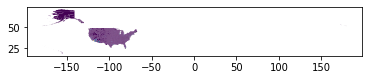

In [2]:
map_data.plot(column = "Population")

The size of the figure and the area covered is too extensive. Before plotting, we will increase the size of the figure and reduce the area plotted (we will exclude Alaska and Hawaii for this purpose). 

Next, let's check the geodataframe.

In [3]:
map_data

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,Population,state,geometry
fips_code,,,,,,,,,,,
21007,21,007,00516850,0500000US21007,Ballard,06,639387454,69473325,7888.0,Kentucky,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
21017,21,017,00516855,0500000US21017,Bourbon,06,750439351,4829777,19788.0,Kentucky,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
21031,21,031,00516862,0500000US21031,Butler,06,1103571974,13943044,12879.0,Kentucky,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
21065,21,065,00516879,0500000US21065,Estill,06,655509930,6516335,14106.0,Kentucky,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
21069,21,069,00516881,0500000US21069,Fleming,06,902727151,7182793,14581.0,Kentucky,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."
21093,21,093,00516893,0500000US21093,Hardin,06,1614569777,17463238,110958.0,Kentucky,"POLYGON ((-86.27756 37.58881, -86.27420 37.589..."
21099,21,099,00516896,0500000US21099,Hart,06,1068530028,13692536,19035.0,Kentucky,"POLYGON ((-86.16112 37.35080, -86.15845 37.351..."
21131,21,131,00516912,0500000US21131,Leslie,06,1038206077,9189732,9877.0,Kentucky,"POLYGON ((-83.55310 37.07928, -83.53528 37.103..."
21151,21,151,00516919,0500000US21151,Madison,06,1132729653,15306635,92987.0,Kentucky,"POLYGON ((-84.52564 37.76950, -84.52350 37.771..."


We can see that counties are identified by a state, with reference to the states fip code, and by a county level fip code. Together, these make the total fip code. We will use the fip code to align the data frames.

Notice also that each observation is associated with an entry under **geometry**. Each entry has identified with it the shape and location of the county identified by a series of coordinates representing the perimeter of the county.

Next, let's call the COVID-19 data.

In [4]:
covid_data

uid location_type location_name    state  \
fips_code date                                                        
1001      2020-01-22  84001001        county       Autauga  Alabama   
          2020-01-23  84001001        county       Autauga  Alabama   
          2020-01-24  84001001        county       Autauga  Alabama   
          2020-01-25  84001001        county       Autauga  Alabama   
          2020-01-26  84001001        county       Autauga  Alabama   
          2020-01-27  84001001        county       Autauga  Alabama   
          2020-01-28  84001001        county       Autauga  Alabama   
          2020-01-29  84001001        county       Autauga  Alabama   
          2020-01-30  84001001        county       Autauga  Alabama   
          2020-01-31  84001001        county       Autauga  Alabama   
          2020-02-01  84001001        county       Autauga  Alabama   
          2020-02-02  84001001        county       Autauga  Alabama   
          2020-02-03  84001001        county       Autauga  Alabama   
          2020-02-04  84001001        county       Autauga  Alabama   
          2020-02-05  84001001        county       Autauga  Alabama   
          2020-02-06  84001001        county       Autauga  Alabama   
          2020-02-07  84001001        county       Autauga  Alabama   
          2020-02-08  84001001        county       Autauga  Alabama   
          2020-02-09  84001001        county       Autauga  Alabama   
          2020-02-10  84001001        county       Autauga  Alabama   
          2020-02-11  84001001        county       Autauga  Alabama   
          2020-02-12  84001001        county       Autauga  Alabama   
          2020-02-13  84001001        county       Autauga  Alabama   
          2020-02-14  84001001        county       Autauga  Alabama   
          2020-02-15  84001001        county       Autauga  Alabama   
          2020-02-16  84001001        county       Autauga  Alabama   
          2020-02-17  84001001        county       Autauga  Alabama   
          2020-02-18  84001001        county       Autauga  Alabama   
          2020-02-19  84001001        county       Autauga  Alabama   
          2020-02-20  84001001        county       Autauga  Alabama   
...                        ...           ...           ...      ...   
56045     2020-10-13  84056045        county        Weston  Wyoming   
          2020-10-14  84056045        county        Weston  Wyoming   
          2020-10-15  84056045        county        Weston  Wyoming   
          2020-10-16  84056045        county        Weston  Wyoming   
          2020-10-17  84056045        county        Weston  Wyoming   
          2020-10-18  84056045        county        Weston  Wyoming   
          2020-10-19  84056045        county        Weston  Wyoming   
          2020-10-20  84056045        county        Weston  Wyoming   
          2020-10-21  84056045        county        Weston  Wyoming   
          2020-10-22  84056045        county        Weston  Wyoming   
          2020-10-23  84056045        county        Weston  Wyoming   
          2020-10-24  84056045        county        Weston  Wyoming   
          2020-10-25  84056045        county        Weston  Wyoming   
          2020-10-26  84056045        county        Weston  Wyoming   
          2020-10-27  84056045        county        Weston  Wyoming   
          2020-10-28  84056045        county        Weston  Wyoming   
          2020-10-29  84056045        county        Weston  Wyoming   
          2020-10-30  84056045        county        Weston  Wyoming   
          2020-10-31  84056045        county        Weston  Wyoming   
          2020-11-01  84056045        county        Weston  Wyoming   
          2020-11-02  84056045        county        Weston  Wyoming   
          2020-11-03  84056045        county        Weston  Wyoming   
          2020-11-04  84056045        county        Weston  Wyoming   
          2020-11-05  84056045        county       

The COVID-19 data also includes a fip_code column in the index. Notice that the index also includes the date. To transform the *covid_data* into a geodataframe, we will need to duplicate the geodataframe for every date in the multi-index of *covid_data*. Once the geodataframe has been developed with an index that matches the *covid_data*, we can add every column from covid_data to the geodataframe by using a for loop to cycle three each key and column of data (key, val) in covid_data.

In [5]:
#COVID19Map.py
# . . .
def create_covid_geo_dataframe(covid_data, map_data, dates):
    # create geopandas dataframe with multiindex for date
    # original geopandas dataframe had no dates, so copies of the df are 
    # stacked vertically, with a new copy for each date in the covid_data index
    #(dates is a global)
    i = 0
    for date in dates:
        # select county observations from each date in dates
        df = covid_data[covid_data.index.get_level_values("date")==date]
        # use the fips_codes from the slice of covid_data to select counties
        # from the map_data index,making sure that the map_data index matches
        # the covid_data index
        counties = df.index.get_level_values("fips_code")
        # call a slice of the geodataframe that includes the counties 
        # that are in covid_data
        agg_df = map_data.loc[counties]
        # each row should reflect the date so that it is aligned 
        # with covid_data
        agg_df["date"] = date
        if i == 0:
            # create the geodataframe, select coordinate system (.crs) to
            # match map_data.crs
            matching_gpd = geopandas.GeoDataFrame(agg_df, crs = map_data.crs)
            i += 1
        else:
            # after initial geodataframe is created, stack a dataframe for
            # each date in dates. Once completed, index of matching_gpd
            # will match index of covid_data
            matching_gpd = matching_gpd.append(agg_df, ignore_index = False)         
    # Set mathcing_gpd index as["fips_code", "date"], liked covid_data index
    matching_gpd.reset_index(inplace=True)
    matching_gpd.set_index(["fips_code","date"], inplace = True)
    # add each column from covid_data to mathcing_gpd
    for key, val in covid_data.items():
        matching_gpd[key] = val
    return matching_gpd       

# . . . to end of script . . .
# dates will be used to create a geopandas DataFrame with multiindex 

dates = sorted(list(set(covid_data.index.get_level_values("date"))))
covid_data = create_covid_geo_dataframe(covid_data, map_data, dates)

In [6]:
covid_data

,,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,Population,state,...,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg,state_abr,Location
fips_code,date,,,,,,,,,,,,,,,,,,,,,
1001,2020-01-22,1,001,00161526,0500000US01001,Autauga,06,1539602123,25706961,55869.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Autauga, AL"
1003,2020-01-22,1,003,00161527,0500000US01003,Baldwin,06,4117546676,1133055836,223234.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Baldwin, AL"
1005,2020-01-22,1,005,00161528,0500000US01005,Barbour,06,2292144655,50538698,24686.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Barbour, AL"
1007,2020-01-22,1,007,00161529,0500000US01007,Bibb,06,1612167481,9602089,22394.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Bibb, AL"
1009,2020-01-22,1,009,00161530,0500000US01009,Blount,06,1670103911,15015423,57826.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Blount, AL"
1011,2020-01-22,1,011,00161531,0500000US01011,Bullock,06,1613059160,6054988,10101.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Bullock, AL"
1013,2020-01-22,1,013,00161532,0500000US01013,Butler,06,2012002530,2701198,19448.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Butler, AL"
1015,2020-01-22,1,015,00161533,0500000US01015,Calhoun,06,1569189622,16627597,113605.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Calhoun, AL"
1017,2020-01-22,1,017,00161534,0500000US01017,Chambers,06,1545085607,16971701,33254.0,Alabama,...,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,AL,"Chambers, AL"


Next, we will normalize the data by population using the *create_new_vars()* function. We will use the population data that I have included with the *.shp* file under the key "*Population*". If you have downloaded the shapefile directly from the census website, than you might prefer to use "*total_population*", which is included in the Associated Press's COVID-19 data.

Calculate deaths as a percent of population, then  multiply that percentage by $10^6$ (one million) to calculate deaths per million. In addition to normalizing the data by population, we will also calculate the 7 day running average of this variable using the *.rolling()* method followed by *.mean()*.

In [7]:
#COVID19Map.py
# . . .
def create_new_vars(covid_data, moving_average_days):
    # use a for loop that performs the same operations on data for cases and for deaths
    for key in ["cases", "deaths"]:
        # create a version of the key with the first letter of each word capitalized
        cap_key = key.title()
        covid_data[cap_key + " per Million"] = covid_data["cumulative_" + key]\
            .div(covid_data["total_population"]).mul(10 ** 6)
        # generate daily data normalized per million population by taking the daily difference within each
        # entity (covid_data.index.names[0]), dividing this value by population and multiplying that value
        # by 1 million 10 ** 6
        covid_data["Daily " + cap_key + " per Million"] = \
            covid_data["cumulative_" + key ].groupby(covid_data.index.names[0])\
            .diff(1).div(covid_data["total_population"]).mul(10 ** 6)
        # taking the rolling average; choice of number of days is passed as moving_average_days
        covid_data["Daily " + cap_key + " per Million MA"] = covid_data["Daily " + \
                  cap_key + " per Million"].rolling(moving_average_days).mean()
# . . .
moving_average_days = 7
create_new_vars(covid_data, moving_average_days)

We are almost ready to create our first map! Much of the same structure for plotting other visualizations in *matplotlib* using *pandas* also applies to using *geopandas* to create maps. We will initiate a figure using *plt.subplots()*. Since we are plotting time series data, we will need to plot only one date at a time. Let's start with the most recent data available.

To start, we need to select data from counties  within the 48 states, otherwise Alaska and Hawaii will be include. This allows the area represented to be much smaller. The measures that are slected are rough estimates, but all that matters is that the 48 states reside within the boundaries chosen. Similar to the *data_processed* variable, I include a *map_bounded* variable so that this computation will not be repeated when the script is run multiple times.

Text(0.5, 1, '2020-11-11\nCOVID-19 in the U.S.')

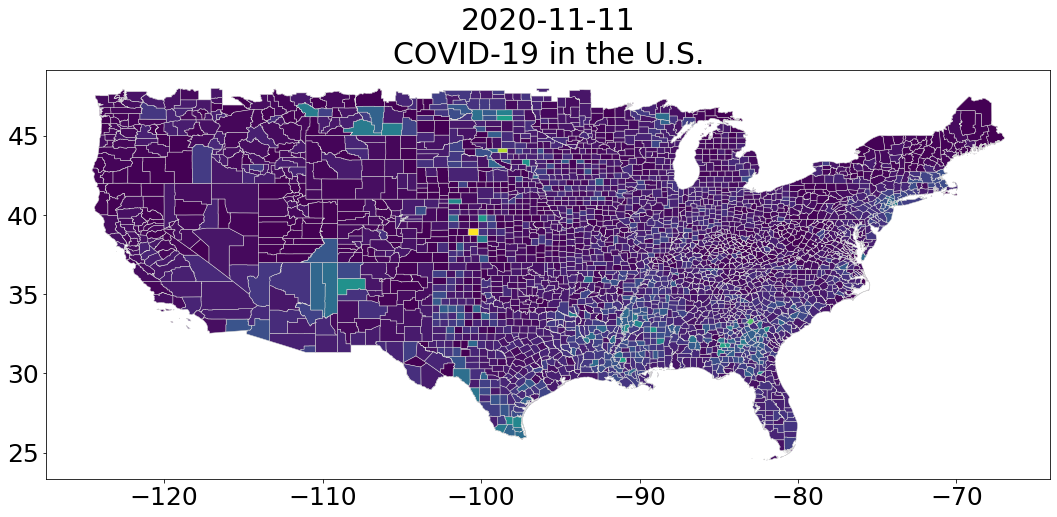

In [8]:
#COVID19Map.py
#. . . 

# only include observations within these boundaries
# this will shrink the size of the map
def select_data_within_bounds(data, minx, miny, maxx, maxy):
    data = data[data.bounds["maxx"] <= maxx]
    data = data[data.bounds["maxy"] <= maxy]
    data = data[data.bounds["minx"] >= minx]
    data = data[data.bounds["miny"] >= miny]
    
    return data

# . . . to end of script
# choose most recent date in data
date = dates[-1]

# choose map bounds
if "map_bounded" not in locals():
    minx = -127
    miny = 23
    maxx = -66
    maxy = 48
    covid_data = select_data_within_bounds(covid_data, minx, miny, maxx, maxy)
    map_bounded = True
    
fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
plt.rcParams.update({"font.size": 30})
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
key = "Deaths per Million"
df = covid_data[covid_data.index.get_level_values("date") == date]
df.plot(ax=ax, cax = ax, column=key, linewidth=.5, 
             edgecolor='lightgrey')
ax.set_title(str(date) + "\n" + "COVID-19 in the U.S.", fontsize = 30)

The result looks okay. A few things can be improved. First, it's usually a good idea to select a colormap that spans a narrow range of colors. For this purpose, we will choose to use the colorbar defined by "Reds" in matplotlib. Color choice also conveys affect to the reader. A choice of color, say "Blues", might  strike the viewer as conveying neutral content. Our choice of red conveys that areas that are darker shades of red tend to have been more greatly impacted by the COVID-19. The variable _"Deaths per Million"_ normalizes death by population, allowing for a fair comparison between counties.

We will also want to limit the variety of shades used for representation. It is easier to interpret data that has been divided into discrete categories. We will choose to use 4 categories representing ranges of increasing size and breadth. 

Since we are plotting levels of values, it will be useful to compare logged values. This will give us a sense that some areas are doing better or worse by orders of magnitude, depending on the plot, about 10 to 20 times better or worse given each change in color. To have colors represent a range of logged values, we use the _cm.colors.LogNorm()_ and apply this with _plt.cm.ScalarMappable()_. We explicitly identify min and max values as this will be useful to us when we plot animations over time later in this lesson.

Finally, in the title, we identify the date, region, and the category of data represented.

Text(0.5, 1, '2020-11-11\nCOVID-19 in the U.S.')

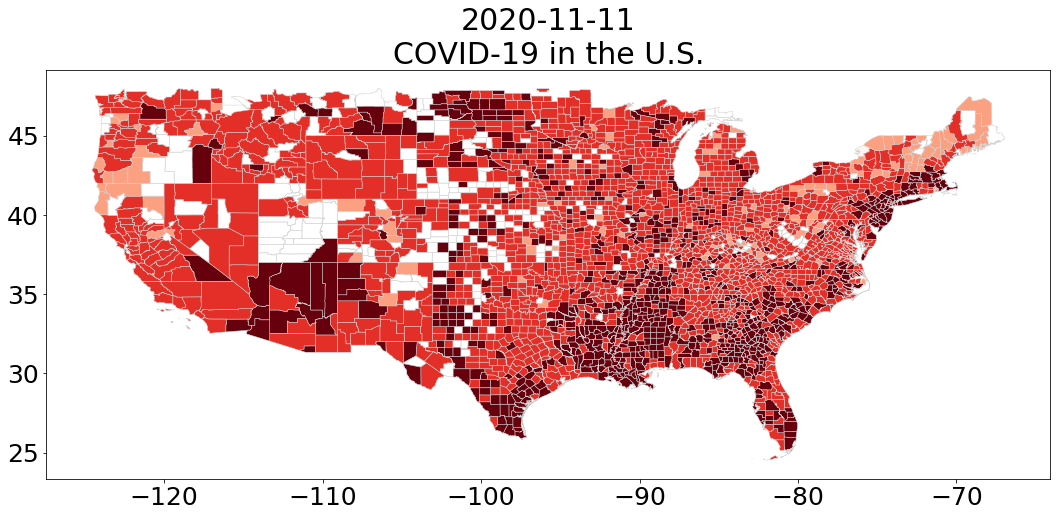

In [9]:
#COVID19Map.py
# . . . to end of script
fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
plt.rcParams.update({"font.size": 30})
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
key = "Deaths per Million"
# change colors, divide into 4 distinct colors
cmap = cm.get_cmap('Reds', 4)
vmin = 1 
vmax = df[key].max()

norm = cm.colors.LogNorm(vmin=vmin, vmax =vmax)
plt.cm.ScalarMappable(cmap=cmap, norm=norm)
df = covid_data[covid_data.index.get_level_values("date") == date]
df.plot(ax=ax, cax = ax, column=key, vmin=vmin ,vmax = vmax, 
             cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
             norm = norm)

ax.set_title(str(date) + "\n" + "COVID-19 in the U.S.", fontsize = 30)

We also want to include a colorbar so that the viewer knows what values are conveyed by map colors. This requires the addition of several parameters that allow for inclusion of a colorbar legend. To construct the colorbar, we need to call *make_axes_locatable(ax)*, then use this to create a colorbar axis, _cax_. Using _cax_ and *cmap*, created in the block of code executed in the previous section, we are able to create a colorbar. To control the value format, we create a list of the axis values, making sure that they are integers (not floats). Then, identify the newly created _matplotlib_ objects in the _.plot()_ method.

Since the color axis is logged, technically it doesn't include a representation for *0*. When passing the dataframe, replace all 0 values with 1 in order to transform the white counties into beige. If you were to use this map, be sure to note that you have made this adjustment.

Text(0.5, 1, '2020-11-11\nCOVID-19 in the U.S.')

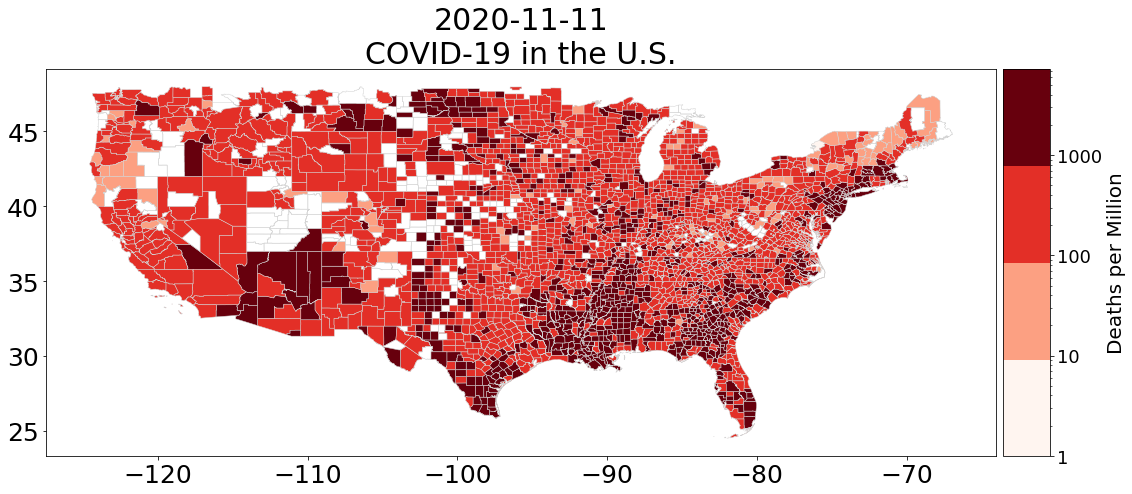

In [10]:
fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
plt.rcParams.update({"font.size": 30})
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
key = "Deaths per Million"
df = covid_data[covid_data.index.get_level_values("date")==date]
cmap = cm.get_cmap('Reds', 4)
vmin = 1 
vmax = df[key].max()
norm = cm.colors.LogNorm(vmin=vmin, vmax =vmax)

############## Add Colorbar ################
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# empty array for the data range
sm._A = []
# prepare space for colorbar
divider = make_axes_locatable(ax)
size = "5%" 
cax = divider.append_axes("right", size = size, pad = 0.1)
# add colorbar to figure
cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
cbar.ax.tick_params(labelsize=18)
vals = list(cbar.ax.get_yticks())
vals.append(vmax)
# format colorbar values as int
cbar.ax.set_yticklabels([int(x) for x in vals])
cbar.ax.set_ylabel(key, fontsize = 20)


df.plot(ax=ax, cax = ax, column=key, vmin=vmin ,vmax = vmax, 
             cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
             norm = norm)
ax.set_title(str(date)[:10] + "\n" + "COVID-19 in the U.S.", fontsize = 30)



Congratulations! You've made a quality map. Next, let's use a for loop to create maps for all for categories that we plotted in the previous post. This is simple. First we define a list of keys, and iterate over each key.

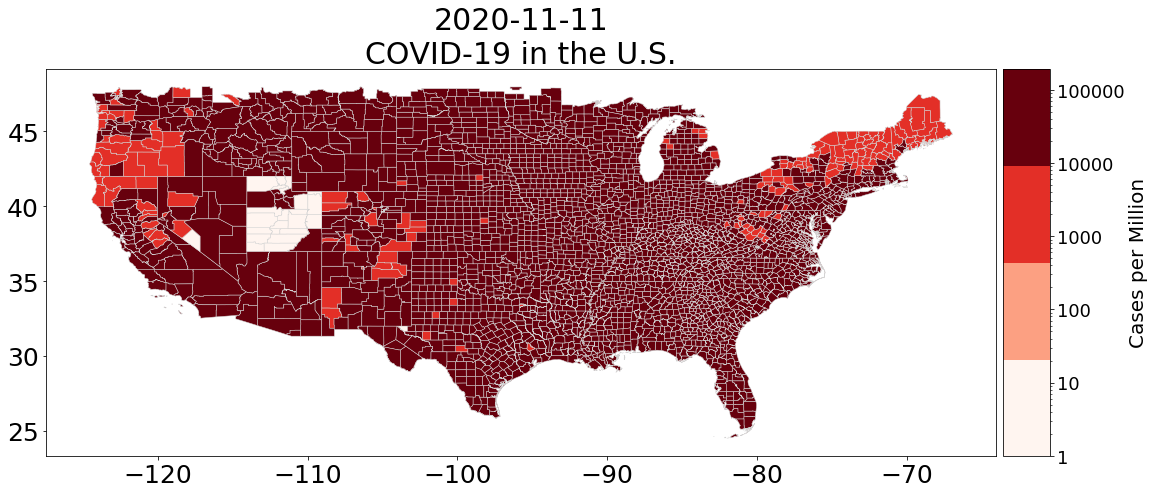

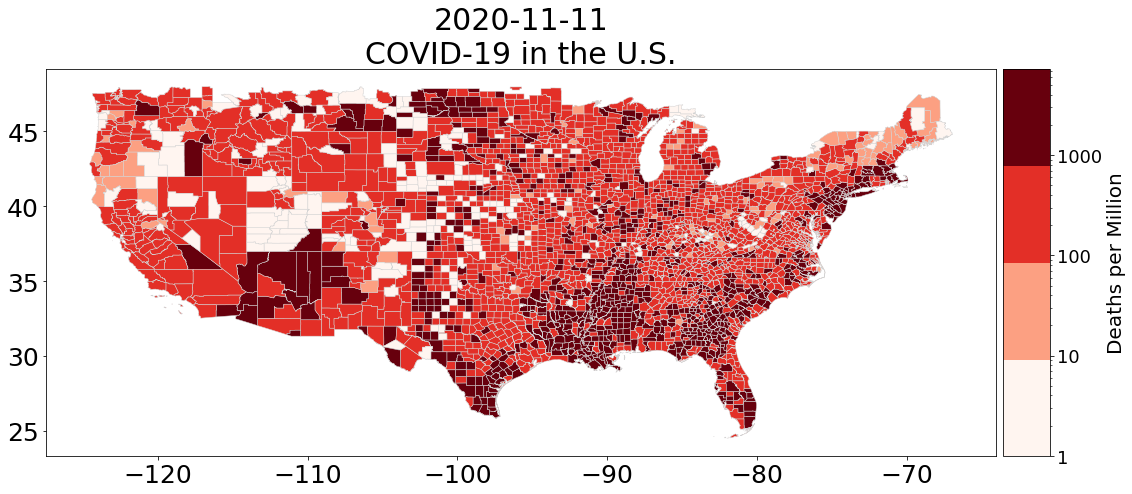

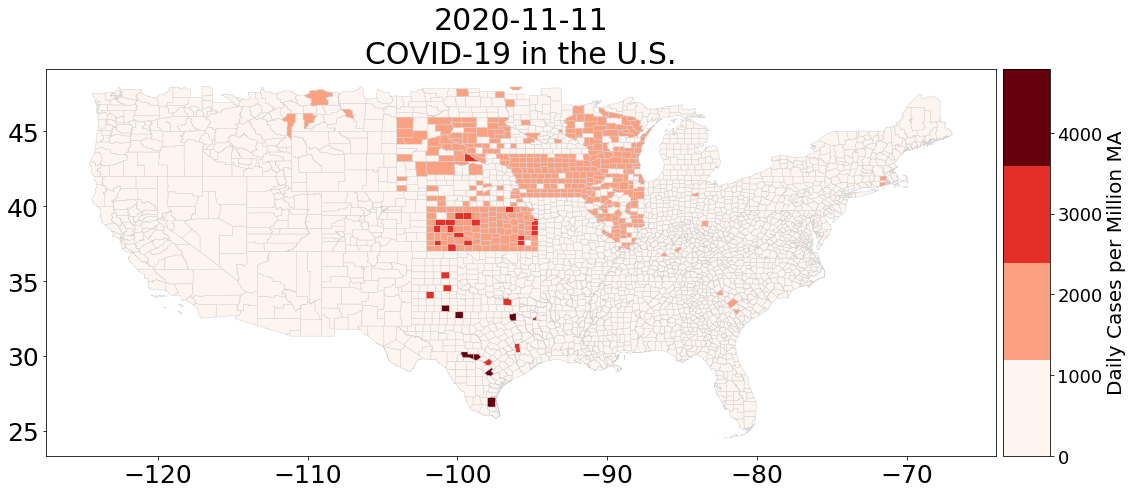

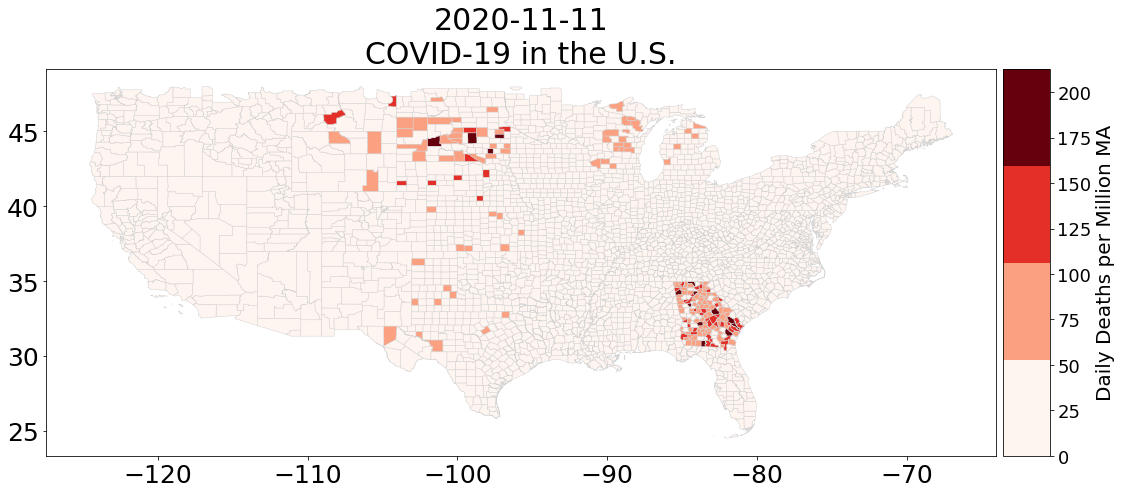

In [11]:
keys = ["Cases per Million", "Deaths per Million", 
        "Daily Cases per Million MA", "Daily Deaths per Million MA"]
for key in keys:
    # identify whether or not to log values for color axis
    # if daily rates, do not log. Only log totals.
    log = False if "Daily" in key else True
    fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
    plt.rcParams.update({"font.size": 30})
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    # this time we replace 0 values with 1
    # so that these values show up as beige instead of as white
    # when color axis is logged
    df = covid_data[covid_data.index.get_level_values("date")==date].replace(0,1)
    # set range of colorbar
    vmin = 1 if log else 0 
    vmax = df[key].max()
    # choose colormap
    cmap = cm.get_cmap('Reds', 4)
    # format colormap
    if log:
        norm = cm.colors.LogNorm(vmin=vmin, vmax =vmax)
    else:
        norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    # empty array for the data range
    sm._A = []
    # prepare space for colorbar
    divider = make_axes_locatable(ax)
    size = "5%" 
    cax = divider.append_axes("right", size = size, pad = 0.1)
    # add colorbar to figure
    cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
    cbar.ax.tick_params(labelsize=18)
    vals = list(cbar.ax.get_yticks())
    vals.append(vmax)

    # format colorbar values as int
    cbar.ax.set_yticklabels([int(x) for x in vals])
    cbar.ax.set_ylabel(key, fontsize = 20)


    df.plot(ax=ax, cax = cax, column=key, vmin=vmin ,vmax = vmax, 
                 cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
                 norm = norm)
    ax.set_title(str(date)[:10] + "\n" + "COVID-19 in the U.S.", fontsize = 30)

    plt.show()
    plt.close()

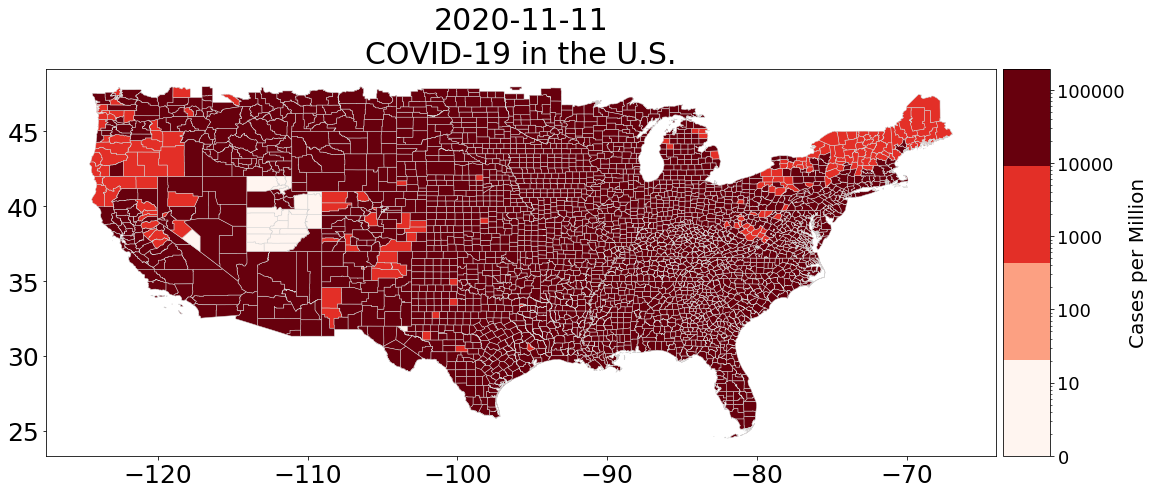

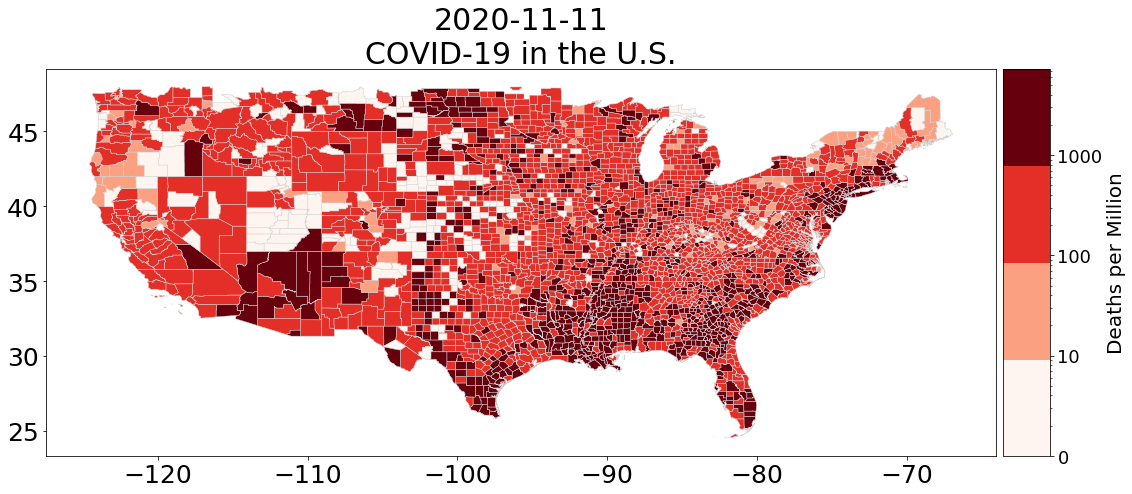

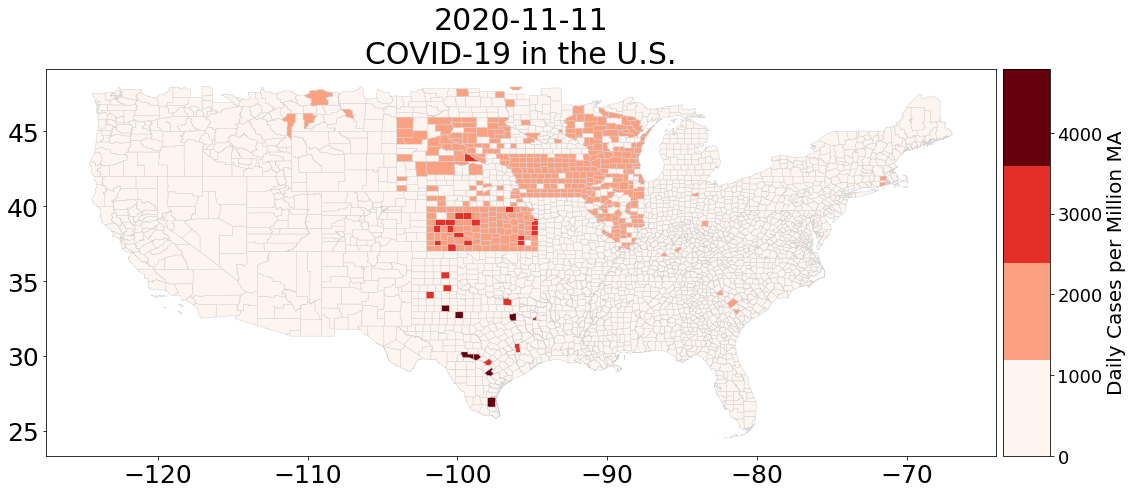

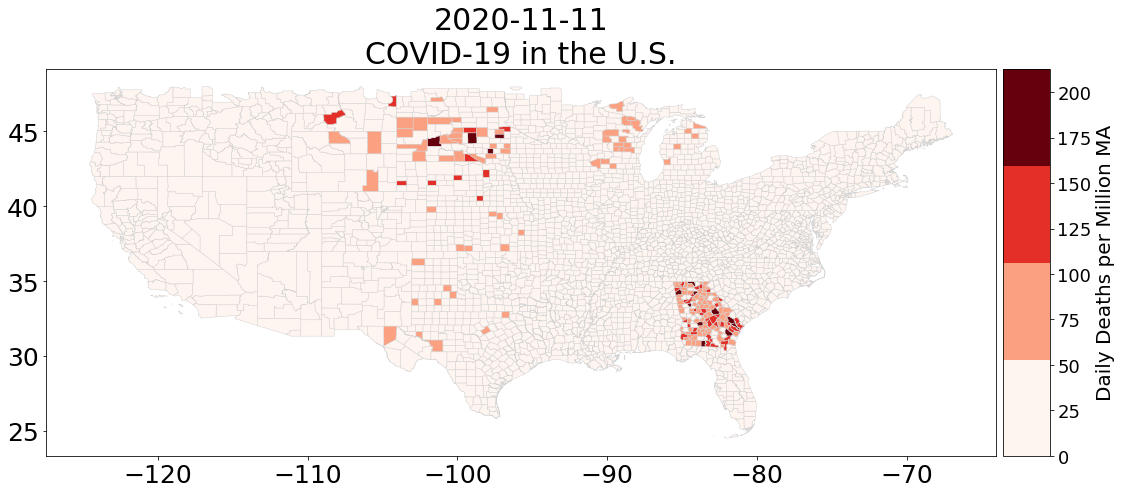

In [12]:
def select_data_within_bounds(data, minx, miny, maxx, maxy):
    data = data[data.bounds["maxx"] <= maxx]
    data = data[data.bounds["maxy"] <= maxy]
    data = data[data.bounds["minx"] >= minx]
    data = data[data.bounds["miny"] >= miny]
    
    return data

def plot_map(*kwargs):
    plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plot_df = df[df.index.get_level_values("date")==date]
    plot_df.plot(ax=ax, cax = ax, column=key, vmin=vmin ,vmax = vmax, 
                 cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
                 norm = norm)
    ax.set_title(str(date)[:10] + "\n" + "COVID-19 in the U.S.", fontsize = 30)
    
def init(*kwargs):
    size = "5%"     
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = size, pad = 0.1)
    # add colorbar to figure
    cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
    cbar.ax.tick_params(labelsize=18)
    vals = list(cbar.ax.get_yticks())
    vals.append(vmax)
    if "Daily" not in key: vals[0] = 0 
    # format colorbar with logged or observed values
    if log:
        cbar.ax.yaxis.set_major_formatter(mtick.LogFormatter())
    else:
        cbar.ax.yaxis.set_major_formatter(mtick.Formatter())
    # format colorbar values as int
    cbar.ax.set_yticklabels([int(x) for x in vals])
    cbar.ax.set_ylabel(key, fontsize = 20)
    
date = dates[-1]
keys = ["Cases per Million", "Deaths per Million", 
        "Daily Cases per Million MA", "Daily Deaths per Million MA"]

if "map_bounded" not in locals():
    minx = -127
    miny = 23
    maxx = -58
    maxy = 54
    covid_data = select_data_within_bounds(covid_data, minx, miny, maxx, maxy)
    map_bounded = True


for key in keys:
    log = False if "Daily" in key else True
    # this time we replace 0 values with 1
    # so that these values show up as beige  instead of as white
    # when color axis is logged
    vmin = 1 if log else 0 
    vmax = df[key][df.index.get_level_values("date") == date].max()
    # Create colorbar as a legend
    cmap = cm.get_cmap('Reds', 4)
    if log:
        norm = cm.colors.LogNorm(vmin=vmin, vmax =vmax)
    else:
        norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)

    fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
    plt.rcParams.update({"font.size": 30})
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    # the functions will unpack the tuple. The same names variable names
    # are used in the function
    kwargs = (df, key, log, date, fig, ax, cmap, norm, vmin, vmax)
    init(kwargs)
    plot_map(kwargs)
    
    plt.show()    

    plt.close()

### Homework

1. Find a way to represent the entire time series in a single file. You may either save a visualization for every data on separate pages in a pdf or you may create an MP4 or GIF file. Make sure that for every frame, the correct date is indicated. See how to accomplish this [here](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/blob/master/Projects/COVID19/Visualizing%20COVID-19%20Data%20at%20the%20State%20and%20County%20Levels%20in%20Python%20-%20Part%20III.ipynb). Differentiate your answer from the template provided in at least 3 ways. Identify *how* your output is differentiated.

2. Select a different time series data (e.g., unemployment, incomes, etc...) set at the county level that has at least 20 observations. Create a map of the latest obervation of the data. Like with the covid data in (1), create a file that holds a visualization for every observation.

*ECON 611 Only*
3. Download and plot data relating to the magnitude of the [policy response](https://github.com/OxCGRT/covid-policy-tracker) by U.S. state or by all nations across the globe. Plot the data on a map as it changes over time using an MP4 file or a GIF. 